## **Install the packages**

In [50]:
!pip install yfinance
!pip install pandas 
!pip install numpy
!pip install seaborn 
!pip install matplotlib
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Import the libraries**

In [51]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf


## **Download the data**

In [52]:
# Select the stocks to test the model
stocks = ['ORCL','EL','NOW','ADI','ISRG','CVS','T','EOG','REGN','TJX']
stocks_compl = ["AAPL"] + stocks

# Download the data for first stock and store it 
apl = yf.Ticker("AAPL")
aapl = apl.history(period ='5y')

# Calculate the returns for the first stock and store it
pct_aapl = aapl["Close"].pct_change()

prices_aapl = aapl["Close"]
returns = pct_aapl.to_frame()
prices = prices_aapl.to_frame()

# Store the generated returns and downloaded data
returns = returns.rename(columns={"Close": stocks_compl[0]})
prices = prices.rename(columns={"Close": stocks_compl[0]})

# Downloading the stocks' data using the 'yfinance' library
for stock in stocks:
    df1 = yf.Ticker(stock)
    df = df1.history(period='5y')

    # Calculate the percent change
    df_pct = df["Close"].pct_change()
    df_price = df["Close"]

    # Store the returns and prices 
    returns = returns.join(df_pct).rename(columns={"Close": stock})
    prices = prices.join(df_price).rename(columns={"Close": stock})

# Remove the empty cells from the returns dataframe 
returns = returns.dropna()

# **TREE CLUSTERING**

<ipython-input-53-2c1a3729e6ed>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(d_corr, 'single')


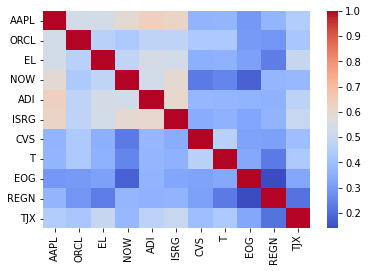

In [53]:
# Compute the correlation matrix 
corr = returns.corr()

# Plot the correlation matrix
ax = sns.heatmap(corr, cmap="coolwarm")

# Calculate the disctance matrix
d_corr = np.sqrt(0.5*(1-corr))

# Compute the linkage matrix using the distance matrix 
link = linkage(d_corr, 'single')
Z = pd.DataFrame(link)

In [54]:
## **Plot the dendogram**

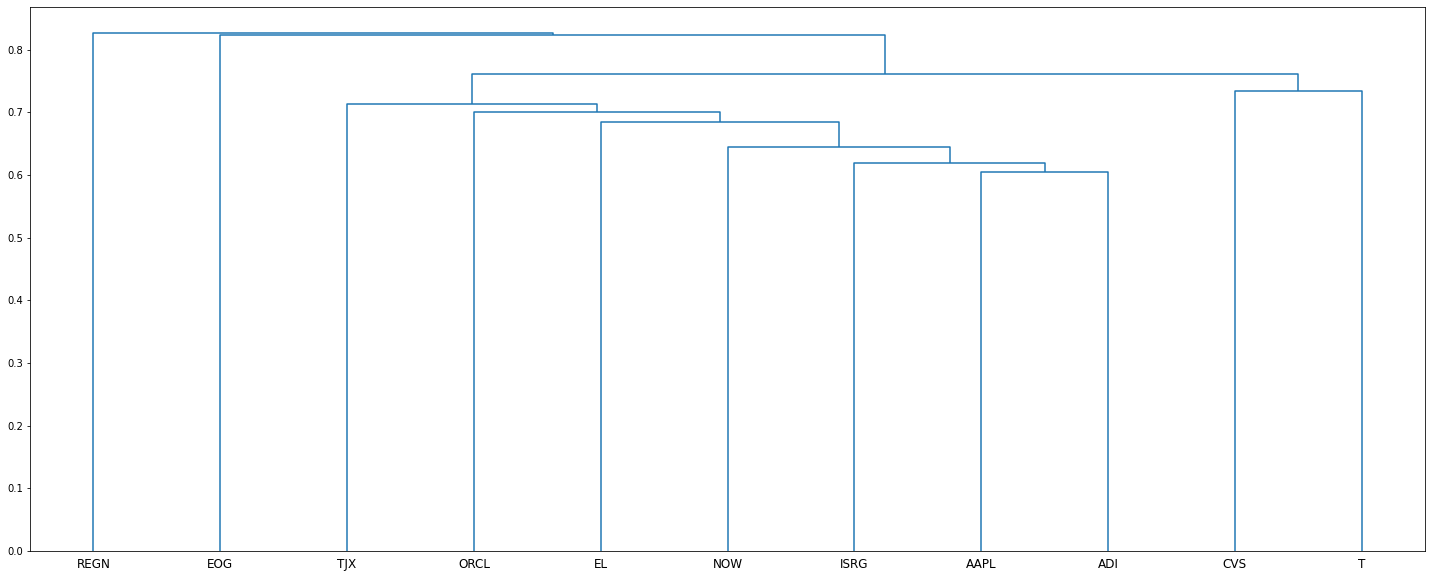

In [55]:
# Plot the dendogram 
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels = stocks_compl)
plt.show()

# **QUASI-DIAGONALIZATION**

In [56]:
# Make a function which returns the sorted matrix back
def get_quasi_diag(link):
    link = link.astype(int)

    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]])

    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2)
        df0 = sort_ix[sort_ix >= num_items] 
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j,0] # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sort_ix = pd.concat([sort_ix,df0])
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

## **Plot the new matrix generated**

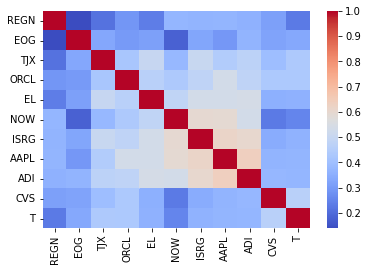

In [57]:
# Call the function to get the sorted matrix

sort_ix = get_quasi_diag(link)
stocks_compl = np.array(stocks_compl)
df_vis = returns[stocks_compl[sort_ix]]
corr2 = df_vis.corr()

# Plot the sorted matrix
ax = sns.heatmap(corr2, cmap="coolwarm")

## **Compute the cluster variance**

In [58]:
# Make a function to get the cluster variance

def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice

    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var


# **RECURSIVE BISECTION**

In [59]:
def get_rec_bipart(cov, sort_ix):

    # compute HRP allocation

    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)

    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        c_items = [i[int(j):int(k)] for i in c_items for j,k in
        ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        # now it has 2
        
        for i in range(0, len(c_items), 2):
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            alpha = 1 - c_var0/(c_var0+c_var1)
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

## **METHODS TO COMPARE THE STRATEGY**

In [60]:
# Compute the weights according to 'minimum variance' method 
def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    x = np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))
    return pd.Series(x, index = stocks_compl, name="MV")

# Compute the weights according to 'risk parity' method
def compute_RP_weights(covariances):
    weights = (1 / np.diag(covariances))
    x = weights / sum(weights)
    return pd.Series(x, index = stocks_compl, name="RP")

# Compute the weights according to 'uniform weights' method
def compute_unif_weights(covariances):
    x = [1 / len(covariances) for i in range(len(covariances))]
    return pd.Series(x, index = stocks_compl, name="unif")

# Compute the weights according to 'hrp' method
cov = returns.cov()
weights_HRP = get_rec_bipart(cov, sort_ix)
new_index = [returns.columns[i] for i in weights_HRP.index]
weights_HRP.index = new_index
weights_HRP.name = "HRP"

## **Store the weights generated from different methods**

In [61]:
# Make a seperate dataframe to store the expected returns generated by all the methods used 

weights_MV = compute_MV_weights(cov)
weights_RP = compute_RP_weights(cov)
weights_unif = compute_unif_weights(cov)

# Make a results dataframe containing results from all the methods
results = weights_HRP.to_frame()
results = results.join(weights_MV.to_frame())
results = results.join(weights_RP.to_frame())
results = results.join(weights_unif.to_frame())
print(results)

           HRP        MV        RP      unif
REGN  0.147988  0.205994  0.090060  0.090909
EOG   0.070056  0.009862  0.042634  0.090909
TJX   0.117135  0.088161  0.095074  0.090909
ORCL  0.094341  0.123186  0.111837  0.090909
EL    0.076308  0.100922  0.090460  0.090909
NOW   0.056189 -0.011348  0.052205  0.090909
ISRG  0.050014 -0.030433  0.075141  0.090909
AAPL  0.059596  0.037256  0.089538  0.090909
ADI   0.099686 -0.011947  0.081204  0.090909
CVS   0.099593  0.144908  0.118390  0.090909
T     0.129093  0.343440  0.153458  0.090909


# **PARAMETERS TO COMPARE THE STRATEGIES**

## **Expected Returns**

In [62]:
# Make a function to compute the expected returns which takes the weight matrix as an argument

def compute_ER(weights):
    mean = returns.mean(0)
    return weights.values * mean

In [63]:
# Pass the weight matrix generated by different methods to the 'compute_ER' function 
# to get the expected returns 

er_hrp = compute_ER(weights_HRP)
er_hrp.name = "HRP"
er_mv = compute_ER(weights_MV)
er_mv.name = "MV"
er_rp = compute_ER(weights_RP)
er_rp.name = "RP"
er_unif = compute_ER(weights_unif)
er_unif.name = "unif"

In [64]:
# Make a seperate dataframe to store the expected returns generated by all the methods used 

ers = er_hrp.to_frame()
ers = pd.concat([ers,er_mv.to_frame()])
ers = pd.concat([ers,er_rp.to_frame()])
ers = pd.concat([ers,er_unif.to_frame()])
ers = ers.sum()
ers.name = "Expected Return"
ers = ers.to_frame()
print(ers)

      Expected Return
HRP          0.000822
MV           0.000483
RP           0.000693
unif         0.000767


## **Portfolio Volitality**

In [65]:
# Make a function to calculate the volitality of the portfolio generated
# by different methods which takes the weight matrix and covariance matrix as arguments 

def portfolio_volatility(weights, cov):
    return np.sqrt(np.dot(np.dot(weights.values, cov.values), weights.values))

In [66]:
# Find the volitality of the various portfolio constructed by different methods

data = [portfolio_volatility(weights_HRP, cov)]
data.append(portfolio_volatility(weights_MV, cov))
data.append(portfolio_volatility(weights_RP, cov))
data.append(portfolio_volatility(weights_unif, cov))
volatility = pd.DataFrame(data = data, index=["HRP", "MV", "RP", "unif"],
columns=["Volatility"])

Assume the risk free return rate to be zero

In [67]:
def risk_free():
    return 0

## **Sharpe Ratio**

In [68]:
# Make a function to calculate the sharpe ratio of all the portfolios 
# which takes the weight matrix and covariance matrix as arguments

def sharpe_ratio(weights, cov):
    ret_portfolio = compute_ER(weights).sum()
    ret_free = risk_free()
    volatility = portfolio_volatility(weights, cov)
    return (ret_portfolio - ret_free)/volatility

In [69]:
# Pass the weight and covariance matrix to the 'sharpe_ratio' function 

data = [sharpe_ratio(weights_HRP, cov)]
data.append(sharpe_ratio(weights_MV, cov))
data.append(sharpe_ratio(weights_RP, cov))
data.append(sharpe_ratio(weights_unif, cov))
sharpe_R= pd.DataFrame(data = data, index=["HRP", "MV", "RP", "unif"],
columns=["Sharpe Ratio"])

# Print the Sharpe ratio dataframe 
print(sharpe_R)

      Sharpe Ratio
HRP       0.054766
MV        0.037591
RP        0.049642
unif      0.052271


## **Maximum Drawdown**

In [70]:
# Make a function to compute the maximum drawdown

def compute_mdd(weights):
    df = weights * prices
    df = df.sum(1)
    roll_max = df.cummax()
    daily_drawdown = df/roll_max - 1.0

In [71]:
# Pass the weights matrix to 'compute_mdd' function and make a 
# seperate dataframe 'dd' to store them

data = [compute_mdd(weights_HRP)]
data.append(compute_mdd(weights_MV))
data.append(compute_mdd(weights_RP))
data.append(compute_mdd(weights_unif))
dd = pd.DataFrame(data = data, index=["HRP", "MV", "RP", "unif"],
columns = ["Max DD"])

## **Diversification Ratio**

In [72]:
# Make a function to compute the diversification ratio for all the portfolios

def diversification_ratio(weights, cov):
    p_volatility = portfolio_volatility(weights, cov)
    return np.dot(np.sqrt(np.diag(cov.values)), weights) / p_volatility

In [73]:
# Pass the weights and covariance matrix to the 'diversification_ratio' function 
# and store the results in a seperate dataframe 'dr'

data = [diversification_ratio(weights_HRP, cov)]
data.append(diversification_ratio(weights_MV, cov))
data.append(diversification_ratio(weights_RP, cov))
data.append(diversification_ratio(weights_unif, cov))
dr = pd.DataFrame(data = data, index=["HRP", "MV", "RP", "unif"],
columns = ["Div Ratio"])

## **FINAL RESULTS**

In [74]:
# Join all the dataframes constructed in one dataframe to get final results

final_results = ers.join(volatility)
final_results = final_results.join(sharpe_R)
final_results = final_results.join(dd)
final_results = final_results.join(dr)
print(final_results)

      Expected Return  Volatility  Sharpe Ratio Max DD  Div Ratio
HRP          0.000822    0.015010      0.054766   None   1.473323
MV           0.000483    0.012849      0.037591   None   1.443498
RP           0.000693    0.013950      0.049642   None   1.478046
unif         0.000767    0.014669      0.052271   None   1.486446
